# Imports

In [3]:

import os
os.chdir("..")
    

In [4]:
%load_ext autoreload
%autoreload all
import pandas as pd
import time
from scipy.stats import pearsonr as pearsonr
import anndata
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from pathlib import Path
import matplotlib.gridspec as gridspec
from Utils.Settings import class_to_division, class_to_broad_division, output_folder_calculations, neuron_cluster_groups_order, manifest, download_base, output_folder, family_name, threshold_expression, genes_families,threshold_expression_MERFISH
from Utils.Utils import  genes_cmap_rgb, cluster_groups_cmap, genes_cmap, percentage_above_threshold, broad_division_color_map, percentage_non_zero, percentage_above_threshold_MER
from scipy.signal import find_peaks
import numpy as np
from scipy.stats import linregress

In [5]:
os.chdir("/alzheimer/Roberto/Github/Transcriptomics-5-HT/")

In [6]:
os.getcwd()

'/alzheimer/Roberto/Github/Transcriptomics-5-HT'

# Load data

In [7]:
metadata = manifest['file_listing']['WMB-10X']['metadata']

In [8]:
rpath = metadata['cell_metadata_with_cluster_annotation']['files']['csv']['relative_path']
file = os.path.join( download_base, rpath )
cell = pd.read_csv(file, keep_default_na=False)
cell.set_index('cell_label',inplace=True)

In [9]:
matrices = cell.groupby(['dataset_label','feature_matrix_label'])[['library_label']].count()
matrices.columns  = ['cell_count']


In [10]:
rpath = metadata['example_genes_all_cells_expression']['files']['csv']['relative_path']
file = os.path.join( download_base, rpath.replace('example_genes_all_cells_expression.csv', f'{family_name}_genes_all_cells_expression.csv'))
exp = pd.read_csv(file)
exp.set_index('cell_label',inplace=True)
exp = exp.sort_index(axis=1)


# Process

In [11]:
cell["division"] = cell['class'].map(class_to_division)
cell["broad_division"] = cell['class'].map(class_to_broad_division)

In [12]:
metadata = manifest['file_listing']['WMB-neighborhoods']['metadata']
rpath = metadata['cluster_group_membership']['files']['csv']['relative_path']
file = os.path.join( download_base, rpath)
group_membership = pd.read_csv(file) # cluster can belong to two different groups


In [13]:
cell_with_membership = cell.reset_index().merge(group_membership[["cluster_group_label", "cluster_alias", "cluster_group_name"]], on='cluster_alias').set_index("cell_label")


In [14]:
cell_with_membership["cluster_group_color"] = cell_with_membership["cluster_group_name"].map(cluster_groups_cmap)
cell['broad_division_color'] = cell['broad_division'].map(broad_division_color_map)

In [15]:
selected_genes = exp.columns.sort_values()

In [16]:
joined = cell.join(exp)
joined_boolean =  cell.join( exp> threshold_expression )
subsampled = joined.loc[::30]

In [17]:
joined_with_membership = cell_with_membership.join(exp)

joined_boolean_with_membership =  cell_with_membership.join( exp>threshold_expression)
subsampled_with_membership = joined_with_membership.loc[::30]

In [18]:
classification_cmap = joined.drop_duplicates(subset='subclass').set_index('subclass')['subclass_color'].to_dict()
classification_cmap.update(joined.drop_duplicates(subset='supertype').set_index('supertype')['subclass_color'].to_dict())
classification_cmap.update(joined.drop_duplicates(subset='cluster').set_index('cluster')['subclass_color'].to_dict())
classification_cmap.update(joined.drop_duplicates(subset='class').set_index('class')['class_color'].to_dict())


In [19]:
_ = joined_boolean[selected_genes]
coloc = {}
for gene in selected_genes:
    coloc[gene] = (_[_[gene]==True].sum()/_[_[gene]==True].shape[0])*100


In [20]:
sub_j = joined_boolean_with_membership[joined_boolean_with_membership['cluster_group_name']!="WholeBrain"][list(selected_genes)+["cluster_group_name"]]

coloc_per_group_and_gene = {}

for gene in selected_genes:
    _ = sub_j[sub_j[gene]==True]
    __={}
    for area in tqdm(_['cluster_group_name'].unique()):
        __[area] = (np.sum(_[_['cluster_group_name']==area][selected_genes].sum(axis=1)>=2)/_[_['cluster_group_name']==area].shape[0])*100
    coloc_per_group_and_gene[gene]=__
    


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

In [21]:
sub_j = joined_boolean_with_membership[joined_boolean_with_membership['cluster_group_name']!="WholeBrain"][list(selected_genes)+["class"]]

coloc_per_class_and_gene = {}

for gene in tqdm(selected_genes):
    _ = sub_j[sub_j[gene]==True]
    __={}
    for area in _['class'].unique():
        __[area] = (np.sum(_[_['class']==area][selected_genes].sum(axis=1)>=2)/_[_['class']==area].shape[0])*100
    coloc_per_class_and_gene[gene]=__
    


  0%|          | 0/14 [00:00<?, ?it/s]

In [22]:
sub_j = joined_boolean_with_membership[joined_boolean_with_membership['cluster_group_name']!="WholeBrain"][list(exp.columns)+["class"]]

data = {}

for gene in tqdm(exp.columns):

    _ = sub_j[sub_j[gene]==True]
    
    for area in _['class'].unique():

        for gene_2 in selected_genes:
        
            data[gene, gene_2, area]= (np.sum(_[_['class']==area][gene_2].sum())/_[_['class']==area].shape[0])*100
    


  0%|          | 0/14 [00:00<?, ?it/s]

In [23]:
coloc_per_class_and_genes = pd.DataFrame(list(data.items()), columns=["Genes", "Value"])
coloc_per_class_and_genes[["Gene1", "Gene2", "Type"]] = pd.DataFrame(coloc_per_class_and_genes["Genes"].tolist(), index=coloc_per_class_and_genes.index)
coloc_per_class_and_genes.drop(columns=["Genes"], inplace=True)

# Load data MERFISH

In [24]:
datasets = ['Zhuang-ABCA-1','Zhuang-ABCA-2','Zhuang-ABCA-3','Zhuang-ABCA-4']

metadata = {}
for d in datasets :
    metadata[d] = manifest['file_listing'][d]['metadata']

In [25]:
cell = {}

for d in datasets :
    
    rpath = metadata[d]['cell_metadata']['files']['csv']['relative_path']
    file = os.path.join( download_base, rpath)
    cell[d] = pd.read_csv(file, dtype={"cell_label":str})
    cell[d].set_index('cell_label',inplace=True)
    
    sdf = cell[d].groupby('brain_section_label')
    
    print(d,":","Number of cells = ", len(cell[d]), ", ", "Number of sections =", len(sdf))

Zhuang-ABCA-1 : Number of cells =  2846908 ,  Number of sections = 147
Zhuang-ABCA-2 : Number of cells =  1227408 ,  Number of sections = 66
Zhuang-ABCA-3 : Number of cells =  1585843 ,  Number of sections = 23
Zhuang-ABCA-4 : Number of cells =  162578 ,  Number of sections = 3


### Cluster annotation

Read in the pivot table from the "cluster annotation tutorial" to associate each cell with terms at each cell type classification level and the corresponding color.

In [26]:
taxonomy_metadata = manifest['file_listing']['WMB-taxonomy']['metadata']

rpath = taxonomy_metadata['cluster_to_cluster_annotation_membership_pivoted']['files']['csv']['relative_path']
file = os.path.join( download_base, rpath)
cluster_details = pd.read_csv(file,keep_default_na=False)
cluster_details.set_index('cluster_alias', inplace=True)

rpath = taxonomy_metadata['cluster_to_cluster_annotation_membership_color']['files']['csv']['relative_path']
file = os.path.join( download_base, rpath)
cluster_colors = pd.read_csv(file)
cluster_colors.set_index('cluster_alias', inplace=True)

cell_extended = {}

for d in datasets :
    cell_extended[d] = cell[d].join(cluster_details,on='cluster_alias')
    cell_extended[d] = cell_extended[d].join(cluster_colors,on='cluster_alias')

For convenience, we can cache this view for later reuse.

### Gene panel

All 4 datasets shares the same 1122 gene panel selected to enable faciliate the mapping to transcriptomically defined cell types taxonomies. Each gene is uniquely identifier by an Ensembl ID. It is best practice to gene identifier to for tracking and data interchange as gene symbols are not unique and can change over time.

Each row of the gene dataframe has Ensembl gene identifier, a gene symbol and name.

In [27]:
rpath = metadata[datasets[0]]['gene']['files']['csv']['relative_path'] # first dataset is big
file = os.path.join( download_base, rpath)
gene = pd.read_csv(file)
gene.set_index('gene_identifier',inplace=True)
print("Number of genes = ", len(gene))

expression_matrices = {}

for d in datasets :
    expression_matrices[d] = manifest['file_listing'][d]['expression_matrices']

gene_filtered  = pd.read_csv(Path(output_folder_calculations, "selected_genes_MERFISH.csv")).set_index("gene_identifier")
selected_genes = np.sort(gene_filtered["gene_symbol"].values)
selected_genes 

Number of genes =  1122


array(['Htr1a', 'Htr1b', 'Htr1d', 'Htr1f', 'Htr2a', 'Htr2c', 'Htr3a',
       'Htr4', 'Htr7'], dtype=object)

In [28]:
cell_expression = {}
cell_expression_bool = {}

for d in datasets :
    
    expression_matrices[d]
    rpath = expression_matrices[d][d]['log2']['files']['h5ad']['relative_path']
    file = os.path.join( download_base, rpath)
    
    adata = anndata.read_h5ad(file,backed='r')
    
    start = time.process_time()
    gdata = adata[:, gene_filtered.index].to_df()
    gdata.columns = gene_filtered.gene_symbol
    cell_expression[d] = cell_extended[d].join( gdata )
    cell_expression_bool[d] = cell_extended[d].join( gdata.astype("bool") )
    
    print(d,"-","time taken: ", time.process_time() - start)
    
    adata.file.close()
    del adata

Zhuang-ABCA-1 - time taken:  39.30756570999995
Zhuang-ABCA-2 - time taken:  14.217265606999945
Zhuang-ABCA-3 - time taken:  17.82984059599994
Zhuang-ABCA-4 - time taken:  2.258109285000046


### CCF registration and parcellation annotation

Each brain specimen has been registered to Allen CCFv3 atlas, resulting in an x, y, z coordinates and parcellation_index for each cell. 

In [29]:
ccf_coordinates = {}

for d in datasets :
    
    rpath = manifest['file_listing'][d+'-CCF']['metadata']['ccf_coordinates']['files']['csv']['relative_path']
    file = os.path.join( download_base, rpath)
    ccf_coordinates[d] = pd.read_csv(file)
    ccf_coordinates[d].set_index('cell_label',inplace=True)
    ccf_coordinates[d].rename(columns={'x':'x_ccf','y':'y_ccf','z':'z_ccf'},inplace=True)
    cell_expression[d] = cell_expression[d].join(ccf_coordinates[d],how='inner')
    cell_expression_bool[d] = cell_expression_bool[d].join(ccf_coordinates[d],how='inner')

metadata_par = manifest['file_listing']['Allen-CCF-2020']['metadata']
rpath = metadata_par['parcellation_to_parcellation_term_membership_acronym']['files']['csv']['relative_path']
file = os.path.join( download_base, rpath)
parcellation_annotation = pd.read_csv(file)
parcellation_annotation.set_index('parcellation_index',inplace=True)
parcellation_annotation.columns = ['parcellation_%s'% x for x in  parcellation_annotation.columns]

rpath = metadata_par['parcellation_to_parcellation_term_membership_color']['files']['csv']['relative_path']
file = os.path.join( download_base, rpath)
parcellation_color = pd.read_csv(file)
parcellation_color.set_index('parcellation_index',inplace=True)
parcellation_color.columns = ['parcellation_%s'% x for x in  parcellation_color.columns]

for d in datasets :
    cell_expression[d] = cell_expression[d].join(parcellation_annotation,on='parcellation_index')
    cell_expression[d] = cell_expression[d].join(parcellation_color,on='parcellation_index')   
    cell_expression_bool[d] = cell_expression_bool[d].join(parcellation_annotation,on='parcellation_index')
    cell_expression_bool[d] = cell_expression_bool[d].join(parcellation_color,on='parcellation_index')   


data_merfish = pd.concat(cell_expression).sort_values(by='brain_section_label')
data_merfish = data_merfish[data_merfish['parcellation_division'] != "unassigned"]

color_dict = data_merfish[[ 'parcellation_division_color','parcellation_division']].drop_duplicates().set_index('parcellation_division').to_dict()['parcellation_division_color']
color_dict.update(data_merfish[[ 'parcellation_structure_color','parcellation_structure']].drop_duplicates().set_index('parcellation_structure').to_dict()['parcellation_structure_color'])

# example gene

In [30]:
gene = list(genes_families.values())[0][3]
gene

'Htr1f'

In [31]:
dataset = 'Zhuang-ABCA-1'
data_merfish_cor = cell_expression[dataset].sort_values(by='brain_section_label')
data_merfish_cor = data_merfish_cor[data_merfish_cor['parcellation_division'] != "unassigned"]
# Choose colors for each section

s = data_merfish_cor.groupby('brain_section_label')[gene].apply(percentage_above_threshold_MER)

# Find the peaks that are at least x distance apart
peaks, _ = find_peaks(s, distance=10)

# Extract these peak values from the series
peak_values = s.iloc[peaks].nlargest(4).sort_index()

section_colors = {
    peak_values.index[0]: '#042A2B',
    peak_values.index[1]: '#5EB1BF',
    peak_values.index[2]: '#CDEDF6',
    peak_values.index[3]: '#EF7B45'
}


In [32]:
# data_merfish_cor_with_membership = data_merfish_cor.reset_index().merge(group_membership[["cluster_group_label", "cluster_alias", "cluster_group_name"]], on='cluster_alias').set_index("cell_label")


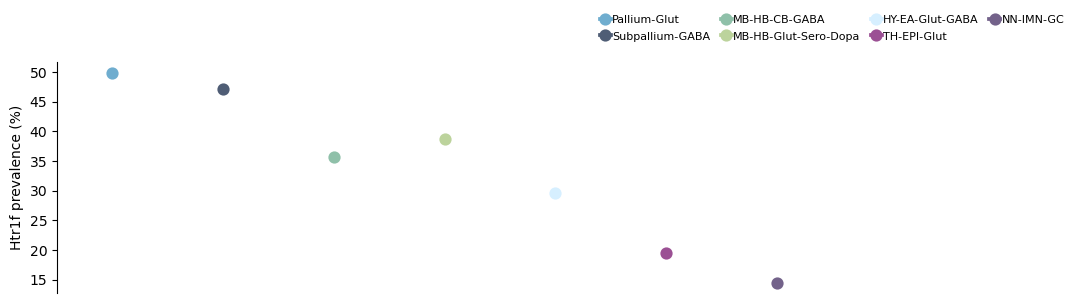

In [33]:
def receptor_prevalence(axs, gene):

    data = joined_with_membership[joined_with_membership["cluster_group_name"]!="WholeBrain"].reset_index(drop=True)
    sns.pointplot(
    data=data, ax=axs, x="cluster_group_name", y=gene, hue="cluster_group_name", 
    palette=cluster_groups_cmap, order=neuron_cluster_groups_order, hue_order=neuron_cluster_groups_order, estimator=percentage_above_threshold, legend=1, errorbar=None,)

    axs.set_xticks([])  # This will remove the x-axis ticks
    axs.set_xticklabels([])  # This will remove the x-axis labels
    axs.set_xlabel("")  # This will remove the x-axis labels
    sns.despine(ax=axs, bottom=True)
    axs.set_ylabel(f"{gene} prevalence (%)")
    legend = axs.legend(loc='upper center', bbox_to_anchor=(1, 1.25), ncol=4, frameon=False, 
                       handlelength=1, handleheight=1, handletextpad =.1, columnspacing=.95, fontsize=8)
    
fig, axs = plt.subplots(figsize=(10,3))
receptor_prevalence (axs, gene)
    

In [34]:
gene="Htr1a"
joined_with_membership[(joined_with_membership["cluster_group_name"]!="WholeBrain") & (joined_with_membership[gene]>0)].groupby("cluster_group_name")[gene].mean()[ neuron_cluster_groups_order]

cluster_group_name
Pallium-Glut            5.861488
Subpallium-GABA         6.007204
MB-HB-CB-GABA           5.940598
MB-HB-Glut-Sero-Dopa    5.620767
HY-EA-Glut-GABA         5.781466
TH-EPI-Glut             5.157041
NN-IMN-GC               6.631721
Name: Htr1a, dtype: float64

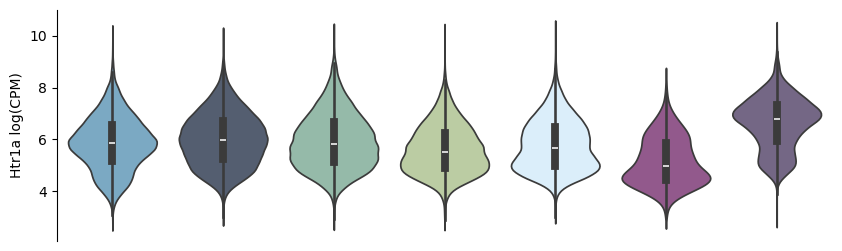

In [35]:
def receptor_expression(axs, gene):
    data = joined_with_membership[(joined_with_membership["cluster_group_name"]!="WholeBrain") & (joined_with_membership[gene]>0)].reset_index(drop=True)
    sns.violinplot(data=data, y=gene,x="cluster_group_name", hue="cluster_group_name" ,ax=axs, palette=cluster_groups_cmap,   order=neuron_cluster_groups_order, hue_order=neuron_cluster_groups_order)
    axs.tick_params(axis='x', rotation=45)
    plt.draw()
    
    for ytick in axs.get_xticklabels():
        ytick.set_color(cluster_groups_cmap[ytick.get_text()])
    sns.despine(ax=axs)
    axs.set_xlabel("")
    axs.set_ylabel(f"{gene} log(CPM)")
    sns.despine(ax=axs, bottom=True)
    axs.set_xticks([])
    axs.set_xticklabels([])
fig, axs = plt.subplots(figsize=(10,3))
receptor_expression(axs, gene)

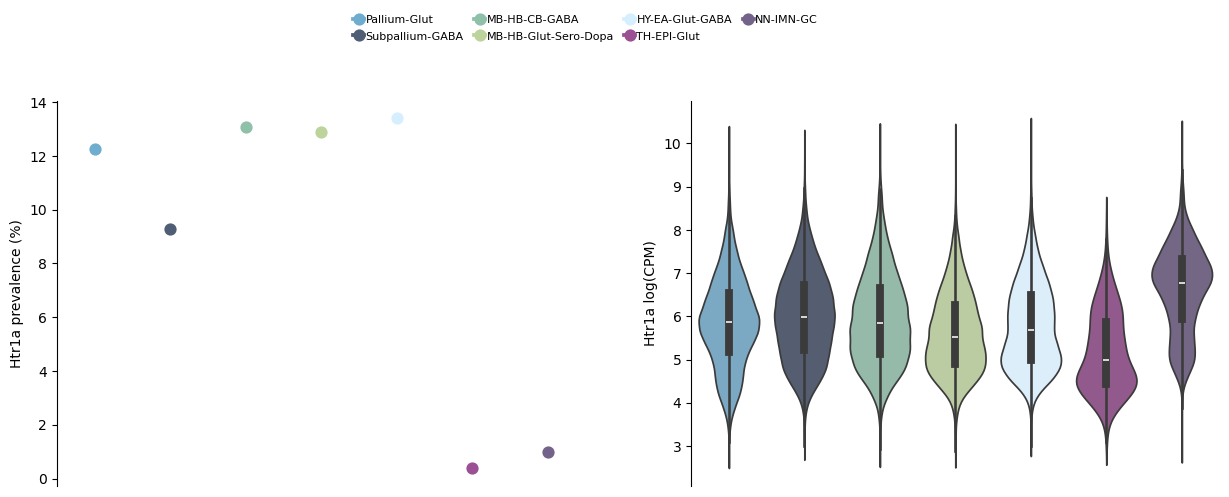

In [36]:

def plot_receptor_transcr_data(axs, gene):
    receptor_prevalence(axs[0], gene)
    receptor_expression(axs[1], gene)
    
fig, axs = plt.subplots(1,2, figsize=(15,5))
plot_receptor_transcr_data(axs, gene)

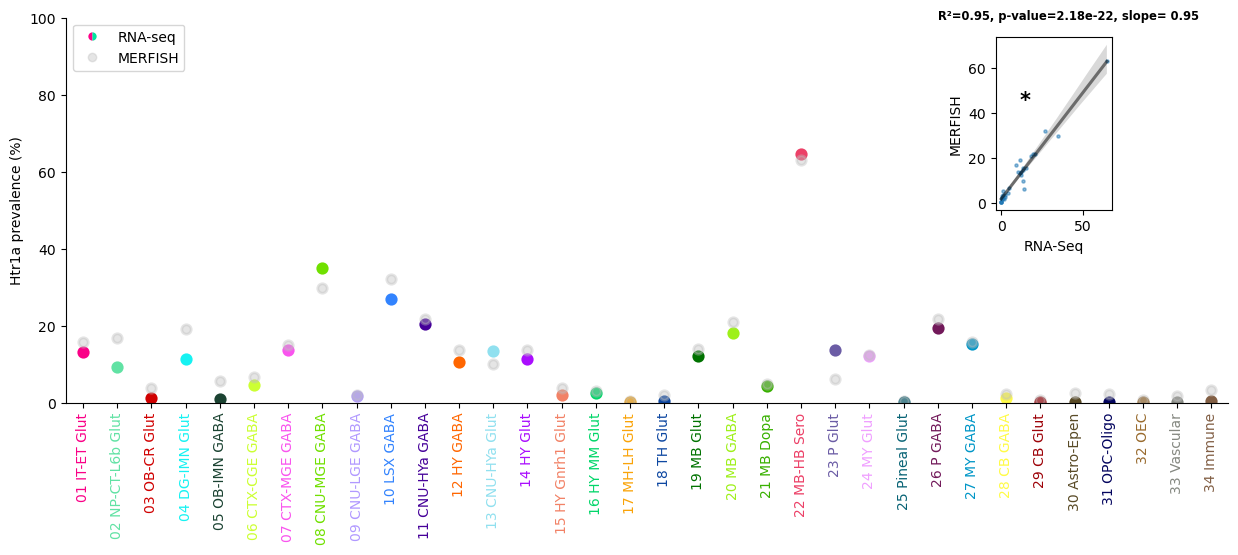

In [37]:
def plot_receptor_transcr_data_per_class(ax, gene):

    sns.pointplot(
    data=joined.reset_index(), 
    y=gene, hue="class", x="class", palette=classification_cmap, estimator=percentage_above_threshold, errorbar=None,
    ax=ax, order=joined["class"].sort_values().unique())

    plt.draw()
    
    for label in ax.get_xticklabels():
        label.set_rotation(90)
        label.set_color(classification_cmap[label.get_text()])
        #label.set_weight('bold')
        


    if gene in data_merfish_cor.columns:
        sns.pointplot(
        data=data_merfish_cor.reset_index(), 
        y=gene,x="class", estimator=percentage_above_threshold_MER, color=".75",  errorbar=None,linestyle='', alpha=.4,
        ax=ax, order=joined["class"].sort_values().unique())
        
        legend_labels = ['RNA-seq', 'MERFISH']
        legend_lines = [plt.Line2D([0], [0], markerfacecolor='#FF0089', fillstyle="left",
                               markerfacecoloralt='#00E69F', marker='o', linestyle='', markeredgewidth=0),
                        plt.Line2D([0], [0], color='.75', marker='o', linestyle='', alpha=.4)]
        ax.legend(handles=legend_lines, labels=legend_labels, loc=2)
    
    
        data = pd.concat([joined.groupby("class")[gene].apply(percentage_above_threshold), data_merfish_cor.groupby("class")[gene].apply(percentage_above_threshold_MER)], axis=1)
        data.columns=["RNA-Seq", "MERFISH"]
    
        axins = ax.inset_axes( [0.8, 0.5, 0.1, 0.45])
        axins.patch.set_alpha(0)  
        
        sns.regplot(data=data, x="RNA-Seq", y= "MERFISH", ax=axins, scatter_kws={ "alpha": .5, 's':5}, line_kws={ "color": "k", "alpha": .5})
    
        r, p = pearsonr(data["RNA-Seq"], data["MERFISH"])

        s,_,_,_,_=linregress(data["RNA-Seq"], data["MERFISH"])
        
        plt.text(-.5, 1.1, f"R\u00b2={round(r ** 2, 2)}, p-value={'{:.2e}'.format(p)}, slope= {round(s,2)}", horizontalalignment='left',
                size="small", color='black', weight='semibold', transform = axins.transAxes, zorder=100)
        if p<.05:
            plt.text(.2, .6, "*", size=15, color='black', weight='semibold', transform = axins.transAxes, zorder=10)


    ax.set_ylim((0,100))
    ax.set_ylabel(f'{gene} prevalence (%)')
    sns.despine()
    ax.set_xlabel("")
    
fig, ax = plt.subplots( figsize=(15,5))
plot_receptor_transcr_data_per_class(ax, gene)

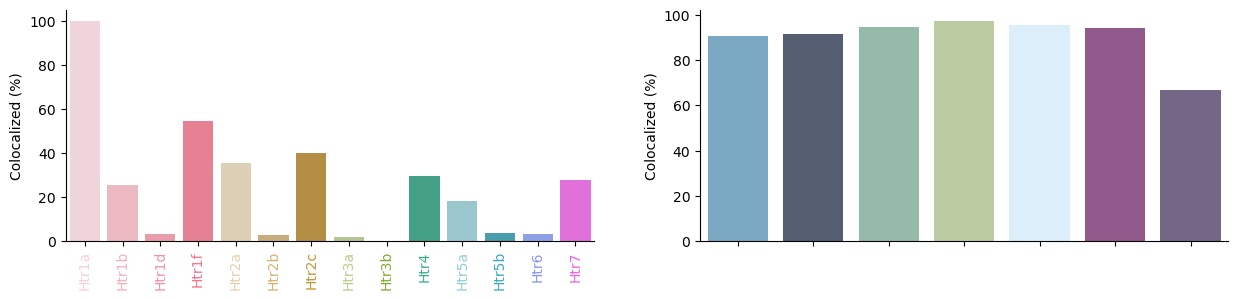

In [38]:
def barplot_coloc(axs, gene):
    _ = pd.DataFrame(coloc[gene], columns=["Colocalized (%)"]).reset_index()


    # Create the line plot
    sns.barplot(data=pd.DataFrame.from_dict(coloc_per_group_and_gene[gene], orient="index", columns=["Colocalized (%)"]).reset_index(),x="index", hue="index",  palette=cluster_groups_cmap, ax=axs[1], order = neuron_cluster_groups_order, y="Colocalized (%)")

    axs[1].set_xlabel("")
    axs[1].set_xticklabels([]) 
    axs[1].set_ylabel("Colocalized (%)")
    
    axs[1].tick_params(axis='x', rotation=90)
    
    sns.barplot(
        data=_,
         y="Colocalized (%)", x="index",hue="index", palette=genes_cmap, ax=axs[0]
    )
    axs[0].tick_params(axis='x', rotation=90)
    axs[0].set_xlabel("")
    
    plt.draw()
    
    for xtick in axs[0].get_xticklabels():
        xtick.set_color(genes_cmap[xtick.get_text()])
    
        
    sns.despine()

fig, axs = plt.subplots(1,2, figsize=(15,3))
barplot_coloc(axs, gene)

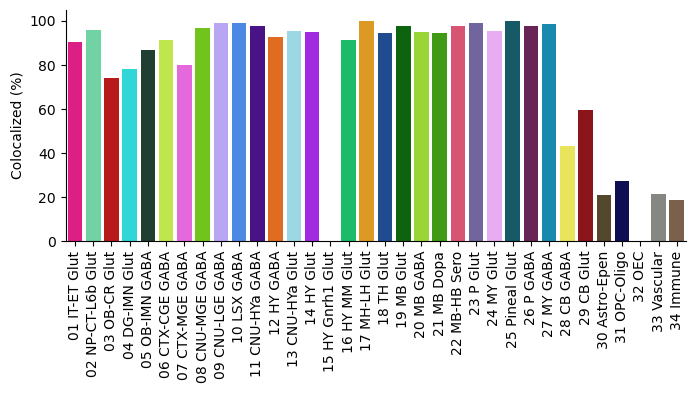

In [39]:
def barplot_coloc_by_class(axs, gene):
    _ = pd.DataFrame(coloc[gene], columns=["Colocalized (%)"]).reset_index()


    # Create the line plot
    sns.barplot(data=pd.DataFrame.from_dict(coloc_per_class_and_gene[gene], orient="index", columns=["Colocalized (%)"]).reset_index(),x="index", hue="index",   ax=axs, y="Colocalized (%)", order= data_merfish_cor["class"].sort_values().unique(),
               palette=classification_cmap)

    axs.set_xlabel("")
    axs.set_ylabel("Colocalized (%)")
    
    axs.tick_params(axis='x', rotation=90)
    
    sns.despine()

fig, axs = plt.subplots(1, figsize=(8,3))
barplot_coloc_by_class(axs, gene)

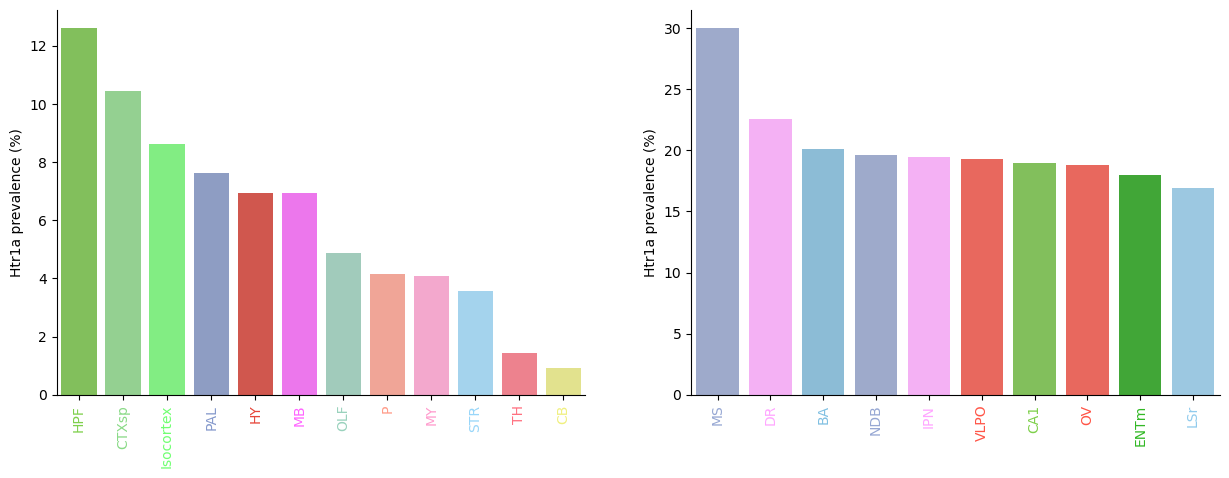

In [41]:
def plot_merfish_expr(axs, gene):
    #filtered_data = data_merfish[(data_merfish['parcellation_category'] == "grey")&(data_merfish[gene] > 0)].groupby(['parcellation_division'])[gene].mean().reset_index()
    #sorted_divisions = (filtered_data.groupby('parcellation_division')[gene].mean().sort_values(ascending=False).index)
    
    #sns.barplot(data=filtered_data, x='parcellation_division', hue='parcellation_division', y=gene, palette=color_dict, order=sorted_divisions, ax=axs[1] )
    #axs[1].tick_params(axis='x', rotation=90)
    #axs[1].set_xlabel('')
    #axs[1].set_ylabel(f"{gene} expression (log)")
    
    filtered_data = data_merfish[data_merfish['parcellation_category'] == "grey"].groupby(['parcellation_division'])[gene].apply(percentage_above_threshold_MER).rename(f"{gene} prevalence (%)").reset_index()
    sorted_divisions = (filtered_data.groupby('parcellation_division')[f"{gene} prevalence (%)"]
                        .mean()
                        .sort_values(ascending=False)
                        .index)
    sns.barplot(data=filtered_data, x='parcellation_division', hue='parcellation_division', y=f"{gene} prevalence (%)", palette=color_dict, order=sorted_divisions, ax=axs[0])
    axs[0].tick_params(axis='x', rotation=90)
    axs[0].set_xlabel('')
    
    filtered_data = data_merfish[data_merfish['parcellation_category'] == "grey"].groupby(['parcellation_structure'])[gene].apply(percentage_above_threshold_MER).rename(f"{gene} prevalence (%)").reset_index().nlargest(10, f'{gene} prevalence (%)')
    sorted_divisions = (filtered_data.groupby('parcellation_structure')[f"{gene} prevalence (%)"]
                        .mean()
                        .sort_values(ascending=False)
                        .index)
    sns.barplot(data=filtered_data, x='parcellation_structure', hue='parcellation_structure', y=f"{gene} prevalence (%)", palette=color_dict, order=sorted_divisions, ax=axs[1])
    axs[1].tick_params(axis='x', rotation=90)
    axs[1].set_xlabel('')
    sns.despine()
    plt.draw()
    for label in axs[0].get_xticklabels():
        label.set_color(color_dict[label.get_text()])
    for label in axs[1].get_xticklabels():
        label.set_color(color_dict[label.get_text()])
        
fig, axs = plt.subplots(1,2, figsize=(15,5))
plot_merfish_expr(axs, gene)

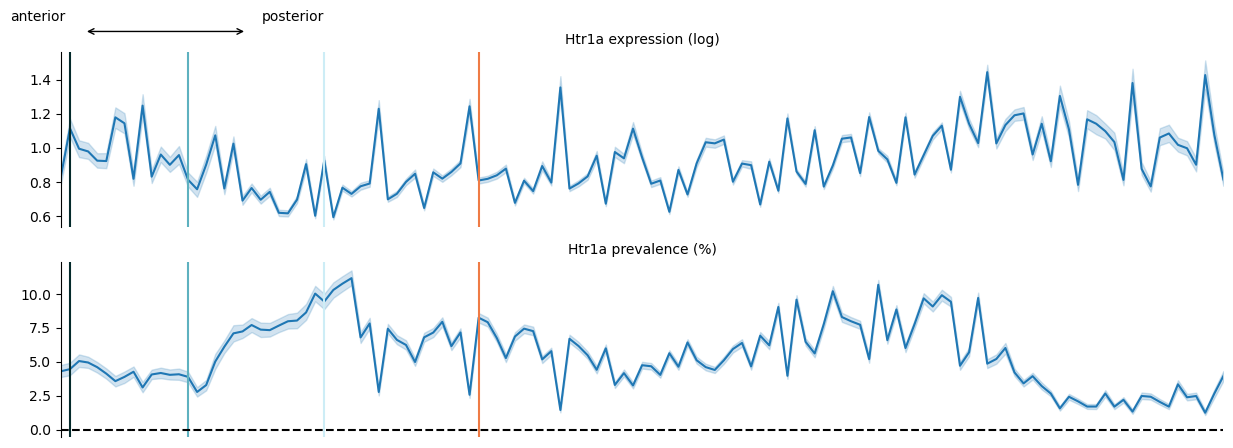

In [42]:
def lineplots_expr_vs_space(axs, section_colors, gene):

    _ =  data_merfish_cor[data_merfish_cor[gene]>0]
    sns.lineplot(data=_, x='brain_section_label', y=gene, ax=axs[0])
    
    # Add colored vertical lines to the top plot
    for section, color in section_colors.items():
        axs[0].axvline(x=section, color=color)
    sns.despine(ax=axs[0], bottom=True)
    
    sns.lineplot(data=data_merfish_cor, x='brain_section_label', y=gene, ax=axs[1], estimator=percentage_above_threshold_MER)
    
    for section, color in section_colors.items():
        axs[1].axvline(x=section, color=color)
    sns.despine(ax=axs[1], bottom=True)
    
    for ax in axs:
        ax.set_xticks([])  # Remove xticks
        ax.set_xticklabels([])  # Remove xticklabels
        ax.set_xlabel("")
        ax.set_xlim([_['brain_section_label'].min(), _['brain_section_label'].max()])
        
    axs[0].set_title(f"{gene} expression (log)",  fontsize=10)
    axs[1].set_title(f"{gene} prevalence (%)", fontsize=10)
    axs[0].set_ylabel("")
    axs[1].set_ylabel("")
    axs[1].set_ylabel("")
    axs[1].axhline(y=0,color="k", linestyle='--')

    # Add double-ended horizontal arrow
    axs[0].annotate("anterior", xy=(-0.02, 1.18), xycoords='axes fraction', fontsize=10, ha="center")
    axs[0].annotate("posterior", xy=(0.2, 1.18), xycoords='axes fraction', fontsize=10, ha="center")
    axs[0].annotate("", xy=(0.02, 1.12), xycoords='axes fraction', xytext=(0.16, 1.12), textcoords='axes fraction',
                arrowprops=dict(arrowstyle="<->", color='black'))

fig, axs = plt.subplots(2, figsize=(15,5))
lineplots_expr_vs_space(axs, section_colors, gene)

In [43]:
def plot_slice(ax, section, gene):
    ax.scatter(section["x"],section["y"],s=0.5, c=section[gene],marker='.',cmap=sns.color_palette("rocket_r", as_cmap=True))
    ax.scatter(-section["x"]+12,section["y"],s=0.5, c=section['parcellation_structure_color'],marker='.')
    ax.set_ylim(11,0)
    ax.set_xlim(0,11)
    ax.axis('equal')
    ax.set_xticks([])
    ax.set_yticks([])


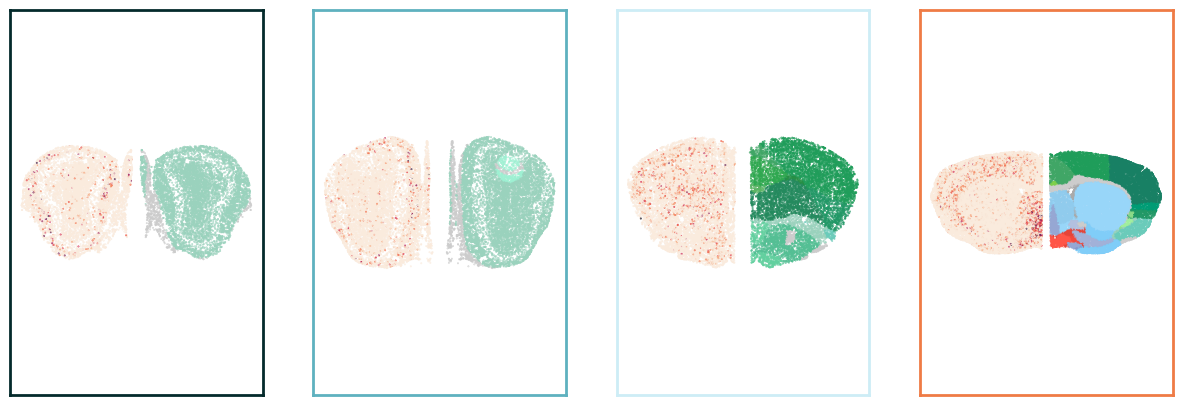

In [44]:
def plot_4_best_sections(axs, section_colors, gene):
    sections = list(section_colors.keys())
    # Below plots
    for i in range(len(section_colors)):
    
        section = data_merfish_cor[data_merfish_cor['brain_section_label'] == sections[i]]
        
        plot_slice(axs[i], section, gene)
        # Set the border color of the subplot
        for spine in axs[i].spines.values():
            spine.set_edgecolor(section_colors[sections[i]])
            spine.set_linewidth(2)  # adjust the width of the border as needed
        
fig, axs = plt.subplots(1,4, figsize=(15,5))

plot_4_best_sections(axs, section_colors, gene)

In [45]:
def plot_figure(gene):
    fig = plt.figure(figsize=(10, 10))
    gs = gridspec.GridSpec(4, 4, height_ratios=[.7,1.3, .7,1])
    
    subfig = fig.add_subfigure(gs[0,:2])
    axs = subfig.subplots(1,2)
    subfig.suptitle("A", x=-.020, y=1.1, fontsize=16, fontweight='bold');
    subfig.subplots_adjust(wspace=.4, left=.1, bottom=.1, top=.9, right=1)
    plot_receptor_transcr_data(axs, gene)
    subfig.set_facecolor('none')

    subfig = fig.add_subfigure(gs[0,2:4])
    axs = subfig.subplots(1,2)
    subfig.suptitle("B", x=0, y=1.1, fontsize=16, fontweight='bold');
    subfig.subplots_adjust(wspace=.4, left=0.15, bottom=.2, top=.98, right=1)
    barplot_coloc(axs, gene)
    subfig.set_facecolor('none')

    subfig = fig.add_subfigure(gs[1,:4])
    axs = subfig.subplots()
    subfig.suptitle("C", x=-.02, y=1, fontsize=16, fontweight='bold');
    subfig.subplots_adjust( left=.05, bottom=.5, top=.9, right=1)
    plot_receptor_transcr_data_per_class(axs, gene)
    subfig.set_facecolor('none')
    
    if gene in data_merfish_cor.columns:
        ####
        #merfish data
        s = data_merfish_cor.groupby('brain_section_label')[gene].apply(percentage_above_threshold_MER)
        
        # Find the peaks that are at least 20 distance apart
        peaks, _ = find_peaks(s, distance=10)
        
        # Extract these peak values from the series
        peak_values = s.iloc[peaks].nlargest(4).sort_index()
        
        section_colors = {
            peak_values.index[0]: '#042A2B',
            peak_values.index[1]: '#5EB1BF',
            peak_values.index[2]: '#CDEDF6',
            peak_values.index[3]: '#EF7B45'
        }

        subfig = fig.add_subfigure(gs[2,:2])
        axs = subfig.subplots(1,2)
        subfig.suptitle("D", x=0, y=1.1, fontsize=16, fontweight='bold');
        subfig.subplots_adjust(wspace=.35, left=0.15, bottom=.2, top=1, right=1)
        plot_merfish_expr(axs, gene)
        subfig.set_facecolor('none')
        
        subfig = fig.add_subfigure(gs[2,2:4])
        axs = subfig.subplots(2)
        subfig.suptitle("E", x=0, y=1.1, fontsize=16, fontweight='bold');
        subfig.subplots_adjust(hspace=0.2,left=0.1, bottom=.1, top=1, right=1)
        lineplots_expr_vs_space(axs, section_colors, gene)
        subfig.set_facecolor('none')
        
        subfig = fig.add_subfigure(gs[3,:])
        axs = subfig.subplots(1,4)
        subfig.suptitle("F", x=-.02, y=.8, fontsize=16, fontweight='bold');
        subfig.subplots_adjust(left=0.05, bottom=.1, top=.8, right=1)
        plot_4_best_sections(axs, section_colors, gene)
        subfig.set_facecolor('none')

    return fig

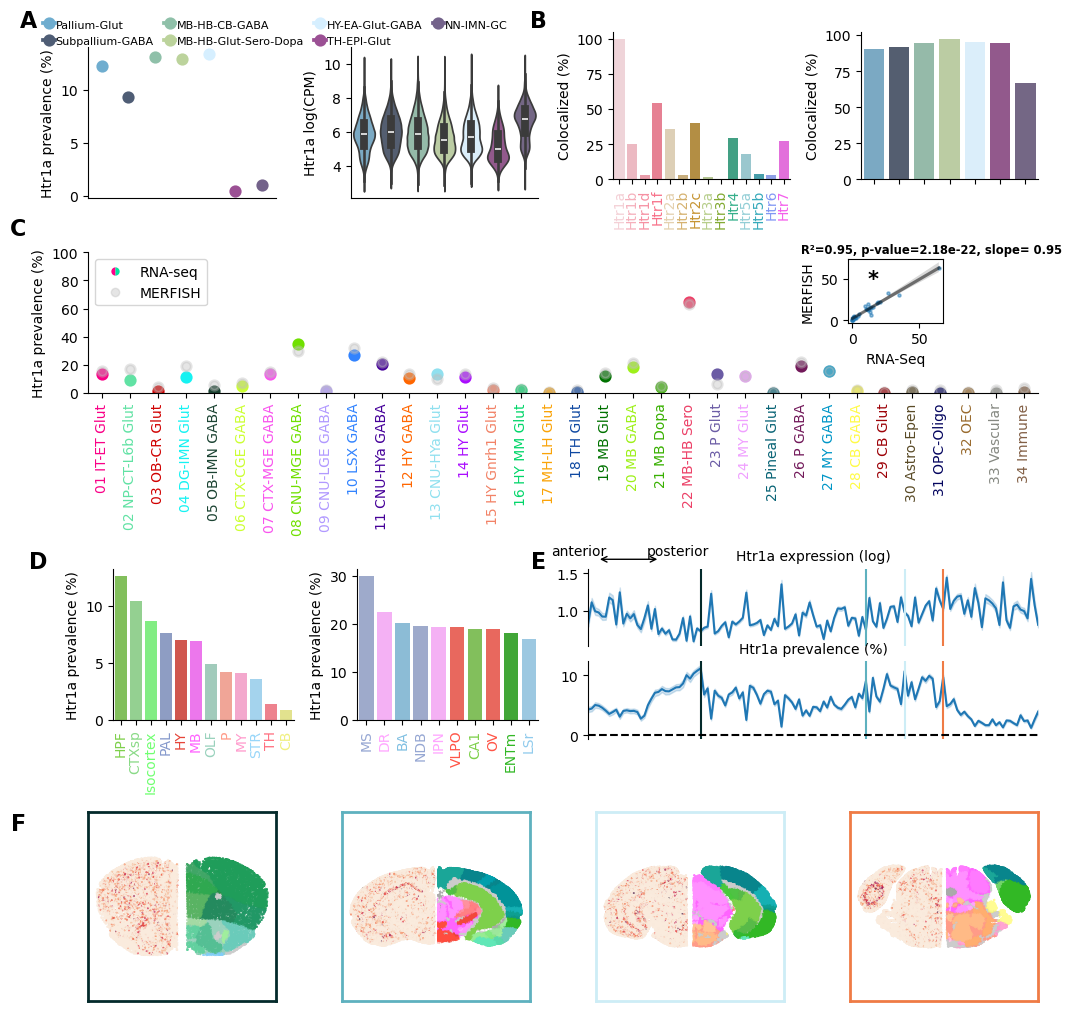

In [46]:
plot_figure("Htr1a");

In [47]:
selected_genes = exp.columns.sort_values() # all genes in rna seq
n=1
nn=1
for gene in tqdm(selected_genes):
    print(gene)
    fig = plot_figure(gene)
    if gene in data_merfish_cor.columns:
        fig.savefig(Path(output_folder, f'Figure_{n}.png'), bbox_inches='tight', dpi=300)
        n=n+1
    else:
        fig.savefig(Path(output_folder, f'Supp_Figure_{nn}.png'), bbox_inches='tight', dpi=300)
        nn=nn+1
    

  0%|          | 0/14 [00:00<?, ?it/s]

ValueError: too many values to unpack (expected 2)